In [1]:
import warnings
warnings.simplefilter('ignore')
from neurocaps.extraction import TimeseriesExtractor
from neurocaps.analysis import CAP, merge_dicts

help(TimeseriesExtractor)
parcel_approach = {"Schaefer": {"n_rois": 100, "yeo_networks": 7}}

extractor = TimeseriesExtractor(parcel_approach=parcel_approach)

Help on class TimeseriesExtractor in module neurocaps.extraction.timeseriesextractor:

class TimeseriesExtractor(neurocaps._utils._timeseriesextractor_internals._timeseriesextractorgetter._TimeseriesExtractorGetter)
 |  TimeseriesExtractor(space: str = 'MNI152NLin2009cAsym', standardize: Union[bool, str] = 'zscore_sample', detrend: bool = False, low_pass: float = None, high_pass: float = None, parcel_approach: dict = {'Schaefer': {'n_rois': 400, 'yeo_networks': 7}}, use_confounds: bool = True, confound_names: list[str] = None, n_acompcor_separate: int = None, dummy_scans: int = None)
 |  
 |  Method resolution order:
 |      TimeseriesExtractor
 |      neurocaps._utils._timeseriesextractor_internals._timeseriesextractorgetter._TimeseriesExtractorGetter
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, space: str = 'MNI152NLin2009cAsym', standardize: Union[bool, str] = 'zscore_sample', detrend: bool = False, low_pass: float = None, high_pass: float = None, p

In [2]:
help(extractor.get_bold)

Help on method get_bold in module neurocaps.extraction.timeseriesextractor:

get_bold(bids_dir: str, session: int, runs: list[int] = None, task: str = 'rest', condition: str = None, tr: Union[int, float] = None, run_subjects: list[str] = None, exclude_subjects: list[str] = None, pipeline_name: str = None, n_cores: Union[bool, int] = None) -> None method of neurocaps.extraction.timeseriesextractor.TimeseriesExtractor instance
    Get Bold Data
    
    Collects files needed to extract timeseries data from NIfTI files for BIDS-compliant datasets.
    
    Parameters
    ----------
    bids_dir : str
        Path to a BIDS compliant directory. 
    session : int
        Session to extract timeseries from. Only a single session can be extracted at a time. 
    runs : list[int]
        Run number to extract timeseries data from. Extracts all runs if unspecified.
    task : str, default="rest"
        Task name.
    condition : str, default=None
        Specific condition in the task to extr

In [3]:
# Attributes

print(dir(extractor))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_parcel_approach', '_setup_extraction', '_signal_clean_info', '_space', 'get_bold', 'n_cores', 'parcel_approach', 'signal_clean_info', 'space', 'subject_ids', 'subject_timeseries', 'task_info', 'timeseries_to_pickle', 'visualize_bold']


In [4]:
# Example structure of what extractor.get_bold() produces; the rows would be equal to the TRs and the columnn would be equal to the number of nodes. 
# So, all subjects would have the same column length which depends on the number inputted in n_nodes when initializing TimeseriesExtractor
# For visualization purposes, I will print out 5 by 5 arrays to show the general structure
import numpy as np

print({str(x) : {f"run-{y}": np.random.rand(5,5) for y in range(1,4)} for x in range(1,2)})

{'1': {'run-1': array([[0.53432258, 0.65116127, 0.62275053, 0.0551794 , 0.99042172],
       [0.75182559, 0.97116155, 0.96497571, 0.96869025, 0.61741483],
       [0.89807984, 0.54824462, 0.60121006, 0.08423446, 0.03980613],
       [0.8308981 , 0.47774355, 0.23963353, 0.81045837, 0.81522468],
       [0.10470894, 0.02085209, 0.87718259, 0.69543563, 0.01778442]]), 'run-2': array([[0.22841544, 0.00943796, 0.11730506, 0.40848928, 0.58873063],
       [0.53842221, 0.95794576, 0.09758011, 0.31713699, 0.14739946],
       [0.86854088, 0.49476189, 0.05590267, 0.80282479, 0.8569499 ],
       [0.61379217, 0.37993019, 0.96189128, 0.54648541, 0.39923053],
       [0.75418322, 0.89873181, 0.40254743, 0.04706239, 0.29816274]]), 'run-3': array([[0.3329316 , 0.14491187, 0.1816937 , 0.08895651, 0.51318422],
       [0.90173547, 0.20721779, 0.80646436, 0.61176522, 0.26457712],
       [0.76104706, 0.64363231, 0.88615136, 0.67070567, 0.0557142 ],
       [0.52648372, 0.26023232, 0.69844159, 0.7361102 , 0.1014486

In [5]:
# Generating a fuller subject timeseries for later cap analysis

extractor._subject_timeseries = {str(x) : {f"run-{y}": np.random.rand(100,100) for y in range(1,4)} for x in range(1,11)}


In [6]:
# Save randomly generated data in directory where jupyter notebook is running

import os, pickle

output_dir = os.path.dirname(__vsc_ipynb_file__)

extractor.timeseries_to_pickle(output_dir=output_dir, file_name="sample_timeseries")

with open("sample_timeseries.pkl", "rb") as f:
    subject_timeseries = pickle.load(f)


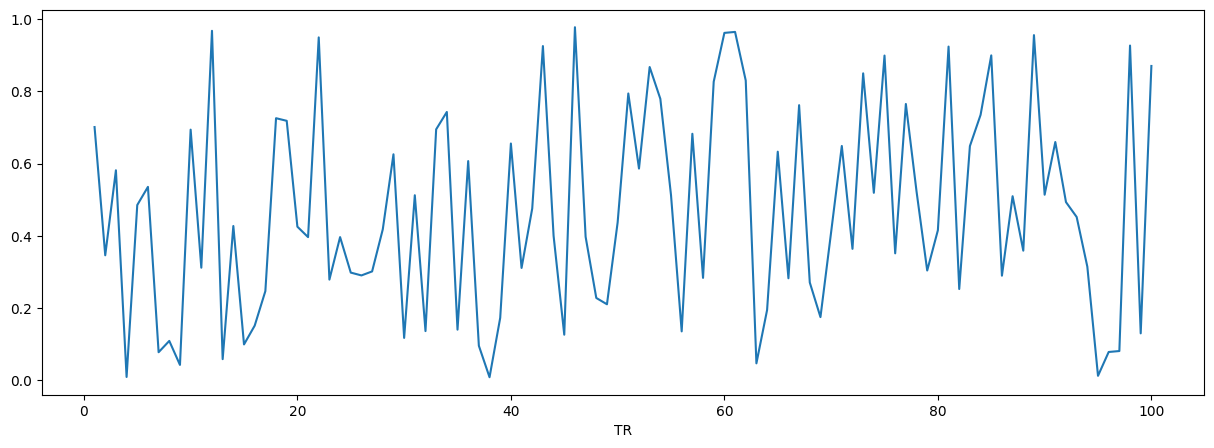

In [7]:
# Visualize Bold at node level

extractor.visualize_bold(subj_id="1",run=1, roi_indx=0)

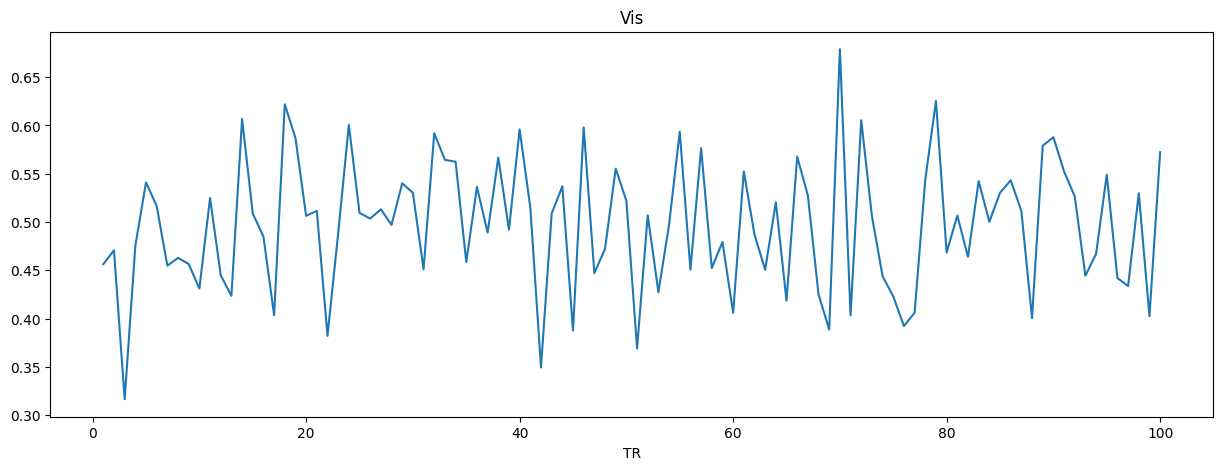

In [8]:
# Visualize Bold at network level

extractor.visualize_bold(subj_id="1",run=1, network="Vis")

In [9]:
# Performing Cap analysis with all subjects 

cap_analysis = CAP(node_labels=extractor.parcel_approach["Schaefer"]["labels"], n_clusters=3)

cap_analysis.get_caps(subject_timeseries=extractor.subject_timeseries)

In [10]:
subject_timeseries.keys()

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

Optimal cluster size for A is 9.

Optimal cluster size for B is 8.



{'A': KMeans(n_clusters=9), 'B': KMeans()}

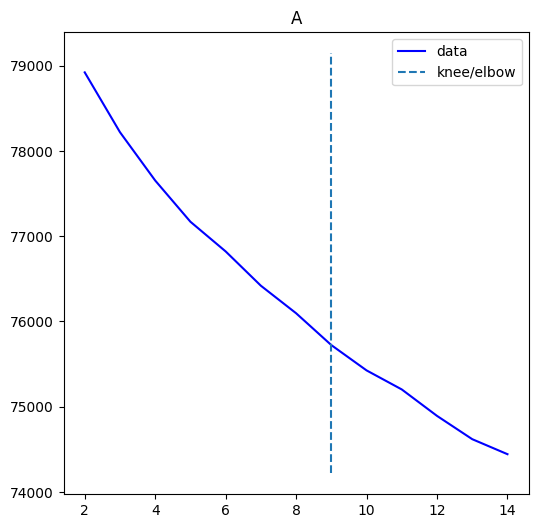

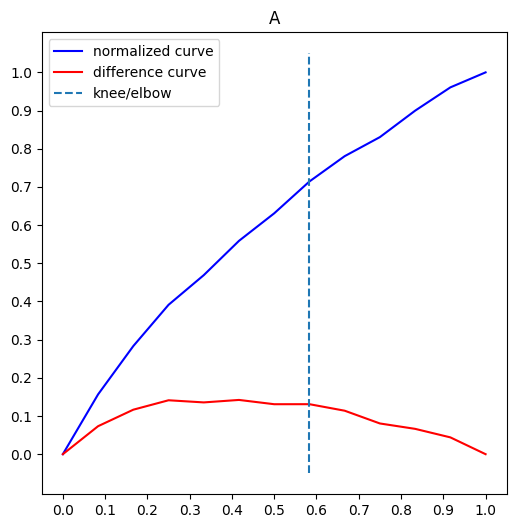

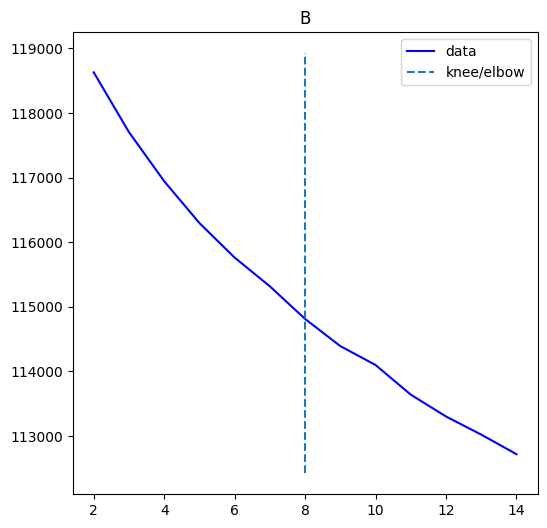

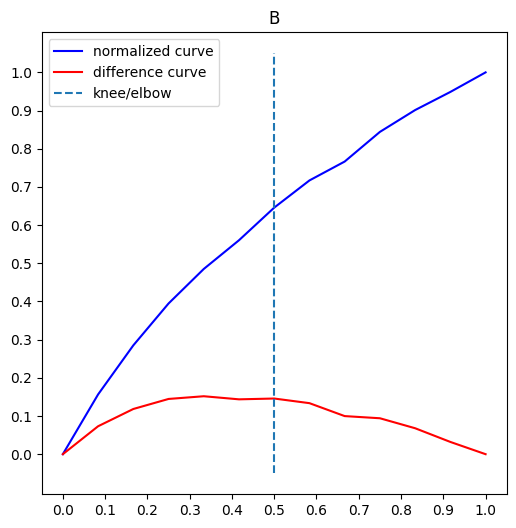

In [11]:
# Performing Cap analysis with groups, list of n_clusters, and elbow cluster selection method

cap_analysis = CAP(node_labels=extractor.parcel_approach["Schaefer"]["labels"], groups={"A": ["1","2","3","5"], "B": ["4","6","7","8","9","10"]}, n_clusters=list(range(2,15)), cluster_selection_method="elbow")

# When elbow method is specified, the associated plots will be shown, furthermore, the saved kmeans model for each group will automatically save to the optimal cluster size
cap_analysis.get_caps(subject_timeseries="sample_timeseries.pkl", runs=[1,2])

cap_analysis.kmeans

In [12]:
# Performing Cap analysis with groups, list of n_clusters, and silhouette cluster selection method

cap_analysis = CAP(node_labels=extractor.parcel_approach["Schaefer"]["labels"], groups={"A": ["1","2","3","5"], "B": ["4","6","7","8","9","10"]}, n_clusters=list(range(2,4)), cluster_selection_method="silhouette")

cap_analysis.get_caps(subject_timeseries="sample_timeseries.pkl")

# kmeans model automatically save to the optimal size
cap_analysis.kmeans

Optimal cluster size for A is 2.
Optimal cluster size for B is 2.


{'A': KMeans(n_clusters=2), 'B': KMeans(n_clusters=2)}

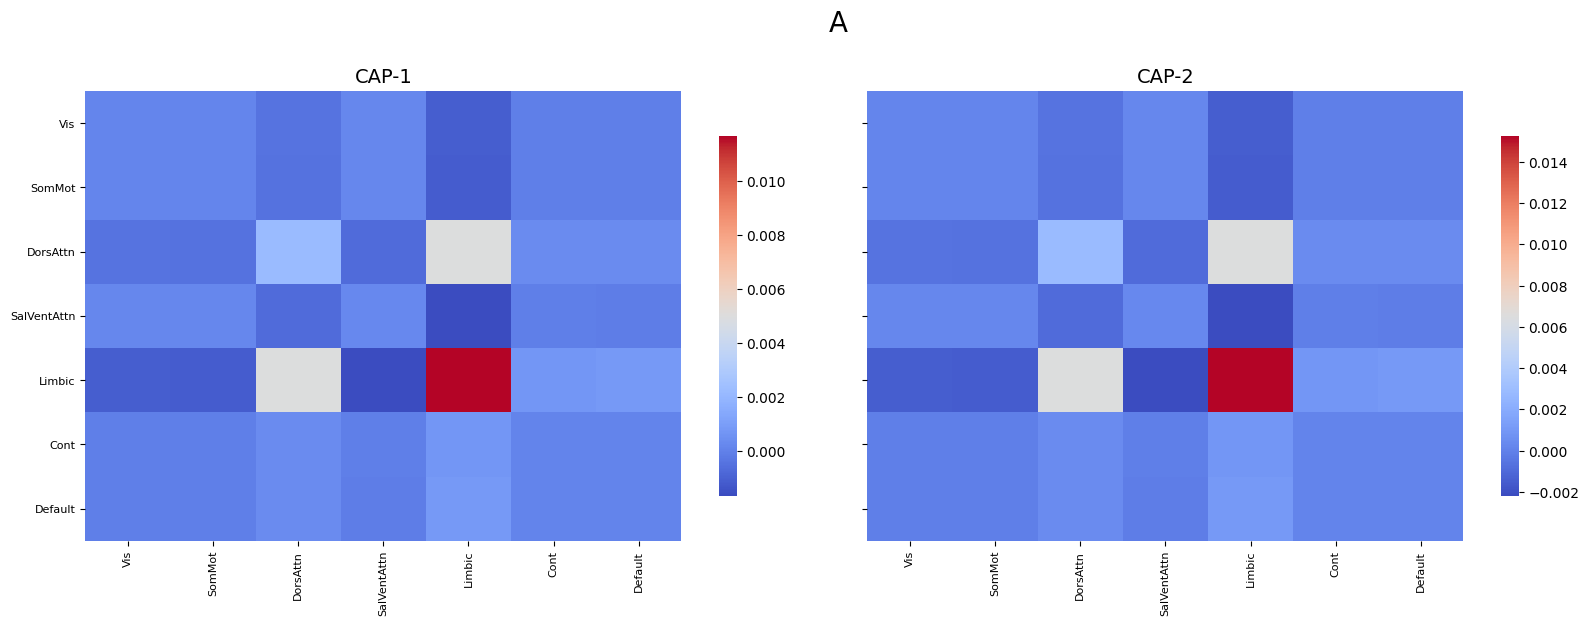

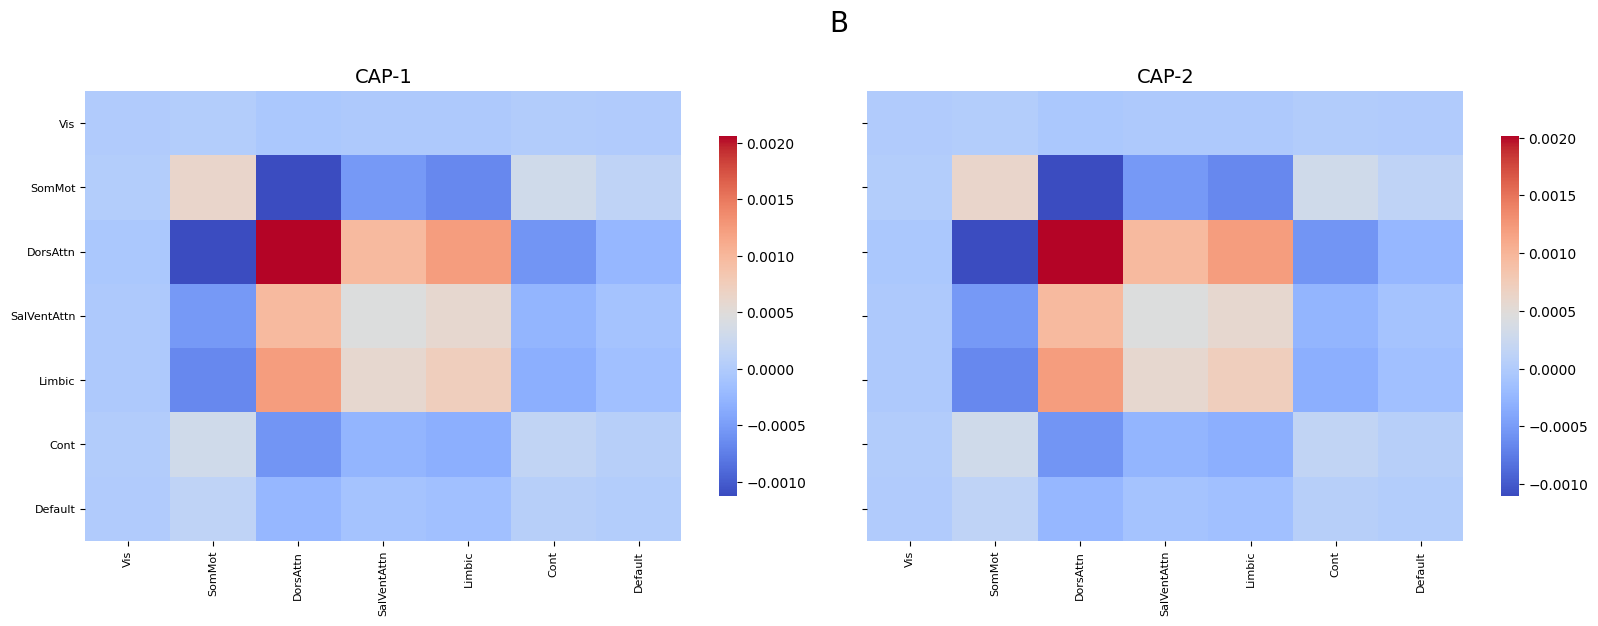

In [13]:
# Visualize Caps
cap_analysis.visualize_caps(subplots=True, xlabel_rotation=90, sharey=True)

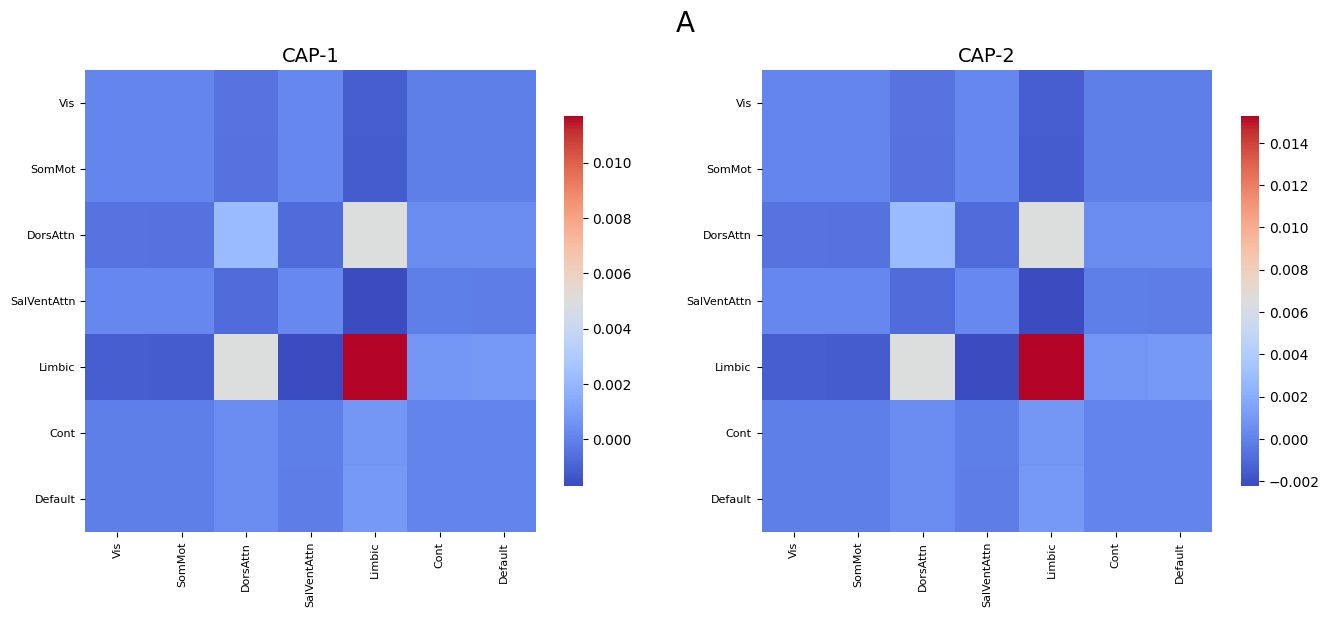

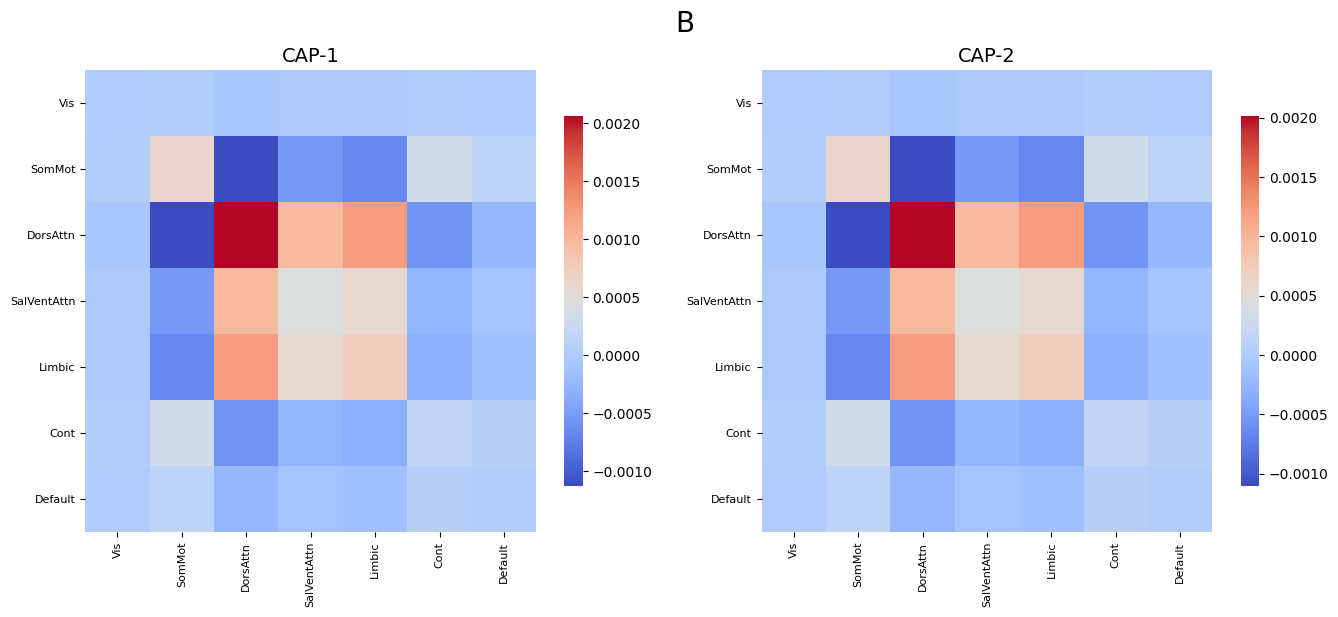

In [14]:
# Visualize Caps
cap_analysis.visualize_caps(subplots=True, xlabel_rotation=90, hspace=0.6, tight_layout=False, sharey = False)

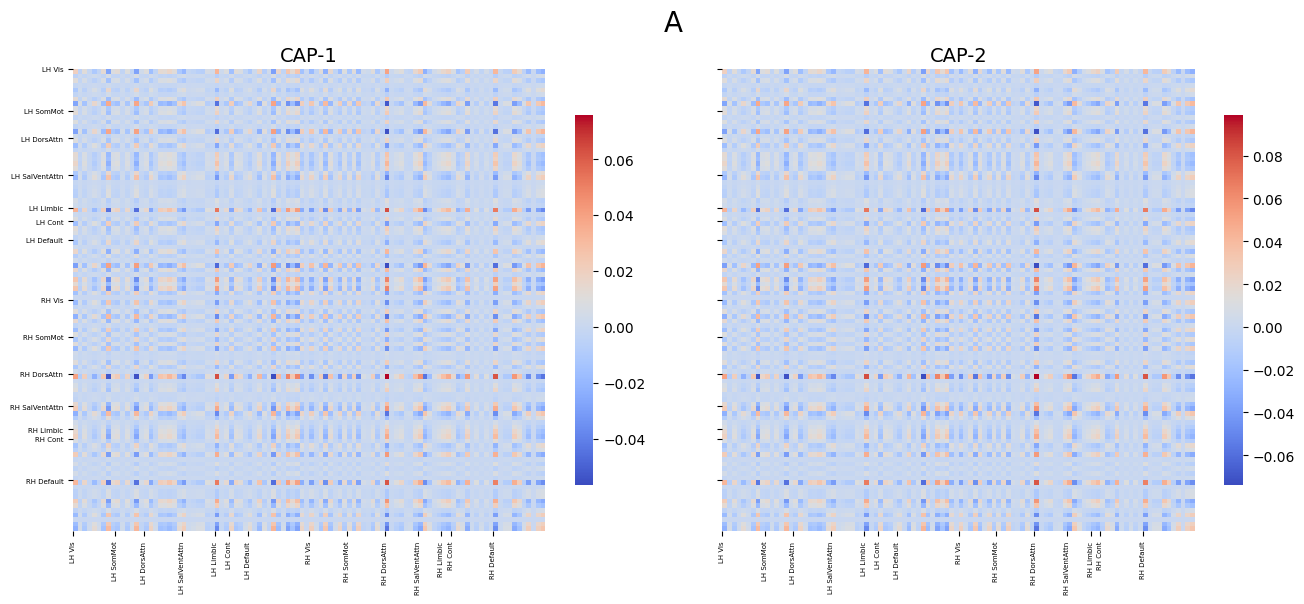

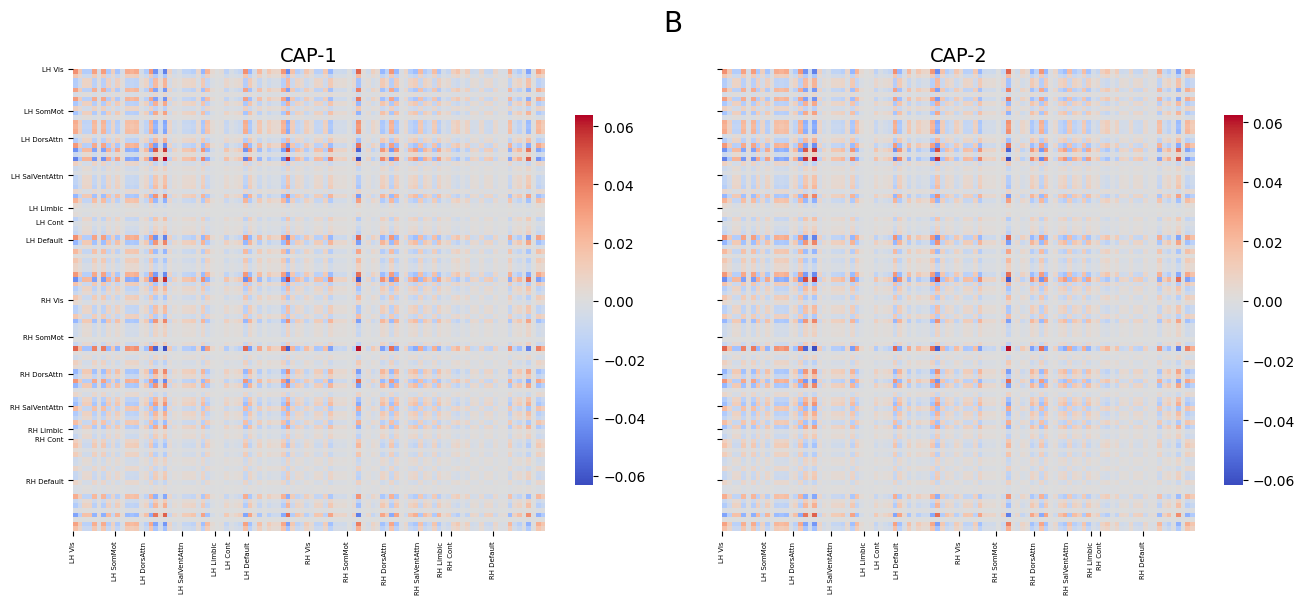

In [15]:
# Change scope from network to nodes

cap_analysis.visualize_caps(subplots=True, yticklabels_size=5, wspace = 0.1, visual_scope="nodes", xlabel_rotation=90, xticklabels_size = 5, hspace = 0.6, tight_layout = False)

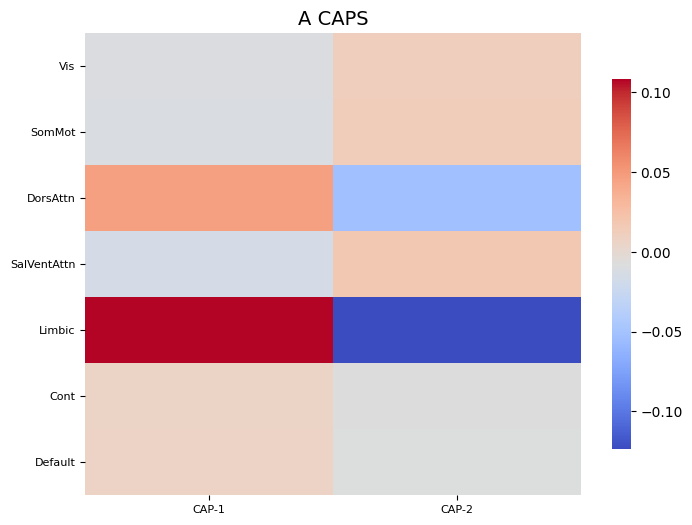

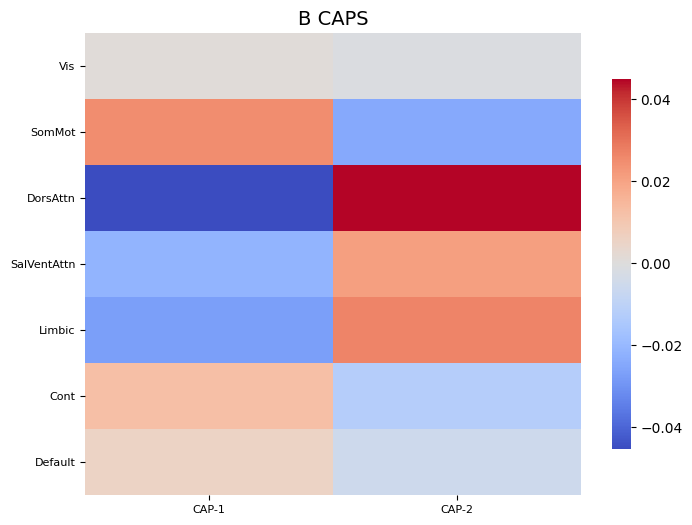

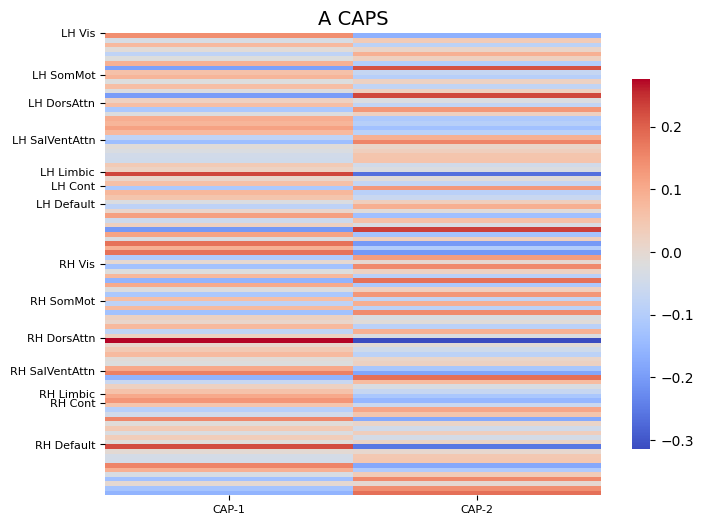

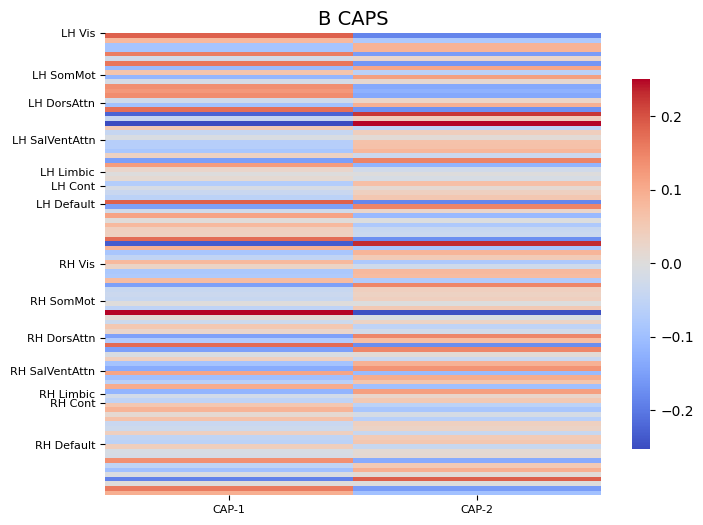

In [16]:
# Get regular heatmap 
cap_analysis.visualize_caps(subplots=True, visual_scope="networks", plot_options="heatmap")
cap_analysis.visualize_caps(subplots=True, visual_scope="nodes", plot_options="heatmap")

In [17]:
# Calculate cap metrics
cap_analysis.calculate_metrics(subject_timeseries=extractor.subject_timeseries,tr=2,metrics="persistence",return_df=True, output_dir=output_dir, file_name="Group_CAPs_metrics")

{'persistence':    Subject_ID Group    Run     CAP-1     CAP-2
 0           1     A  run-1  3.851852  3.555556
 1           1     A  run-2  3.642857  3.500000
 2           1     A  run-3  3.925926  3.357143
 3           2     A  run-1  3.419355  3.032258
 4           2     A  run-2  4.727273  4.173913
 5           2     A  run-3  4.370370  2.928571
 6           3     A  run-1  4.869565  3.826087
 7           3     A  run-2  4.608696  3.916667
 8           3     A  run-3  3.586207  3.200000
 9           5     A  run-1  3.629630  3.777778
 10          5     A  run-2  5.400000  4.600000
 11          5     A  run-3  5.333333  4.190476
 12          4     B  run-1  3.555556  3.714286
 13          4     B  run-2  3.310345  3.586207
 14          4     B  run-3  4.761905  4.761905
 15          6     B  run-1  5.217391  3.478261
 16          6     B  run-2  4.521739  4.173913
 17          6     B  run-3  3.629630  3.777778
 18          7     B  run-1  4.695652  4.000000
 19          7     B  run

Invalid kwargs arguments used and will be ignored {'y': -3}.


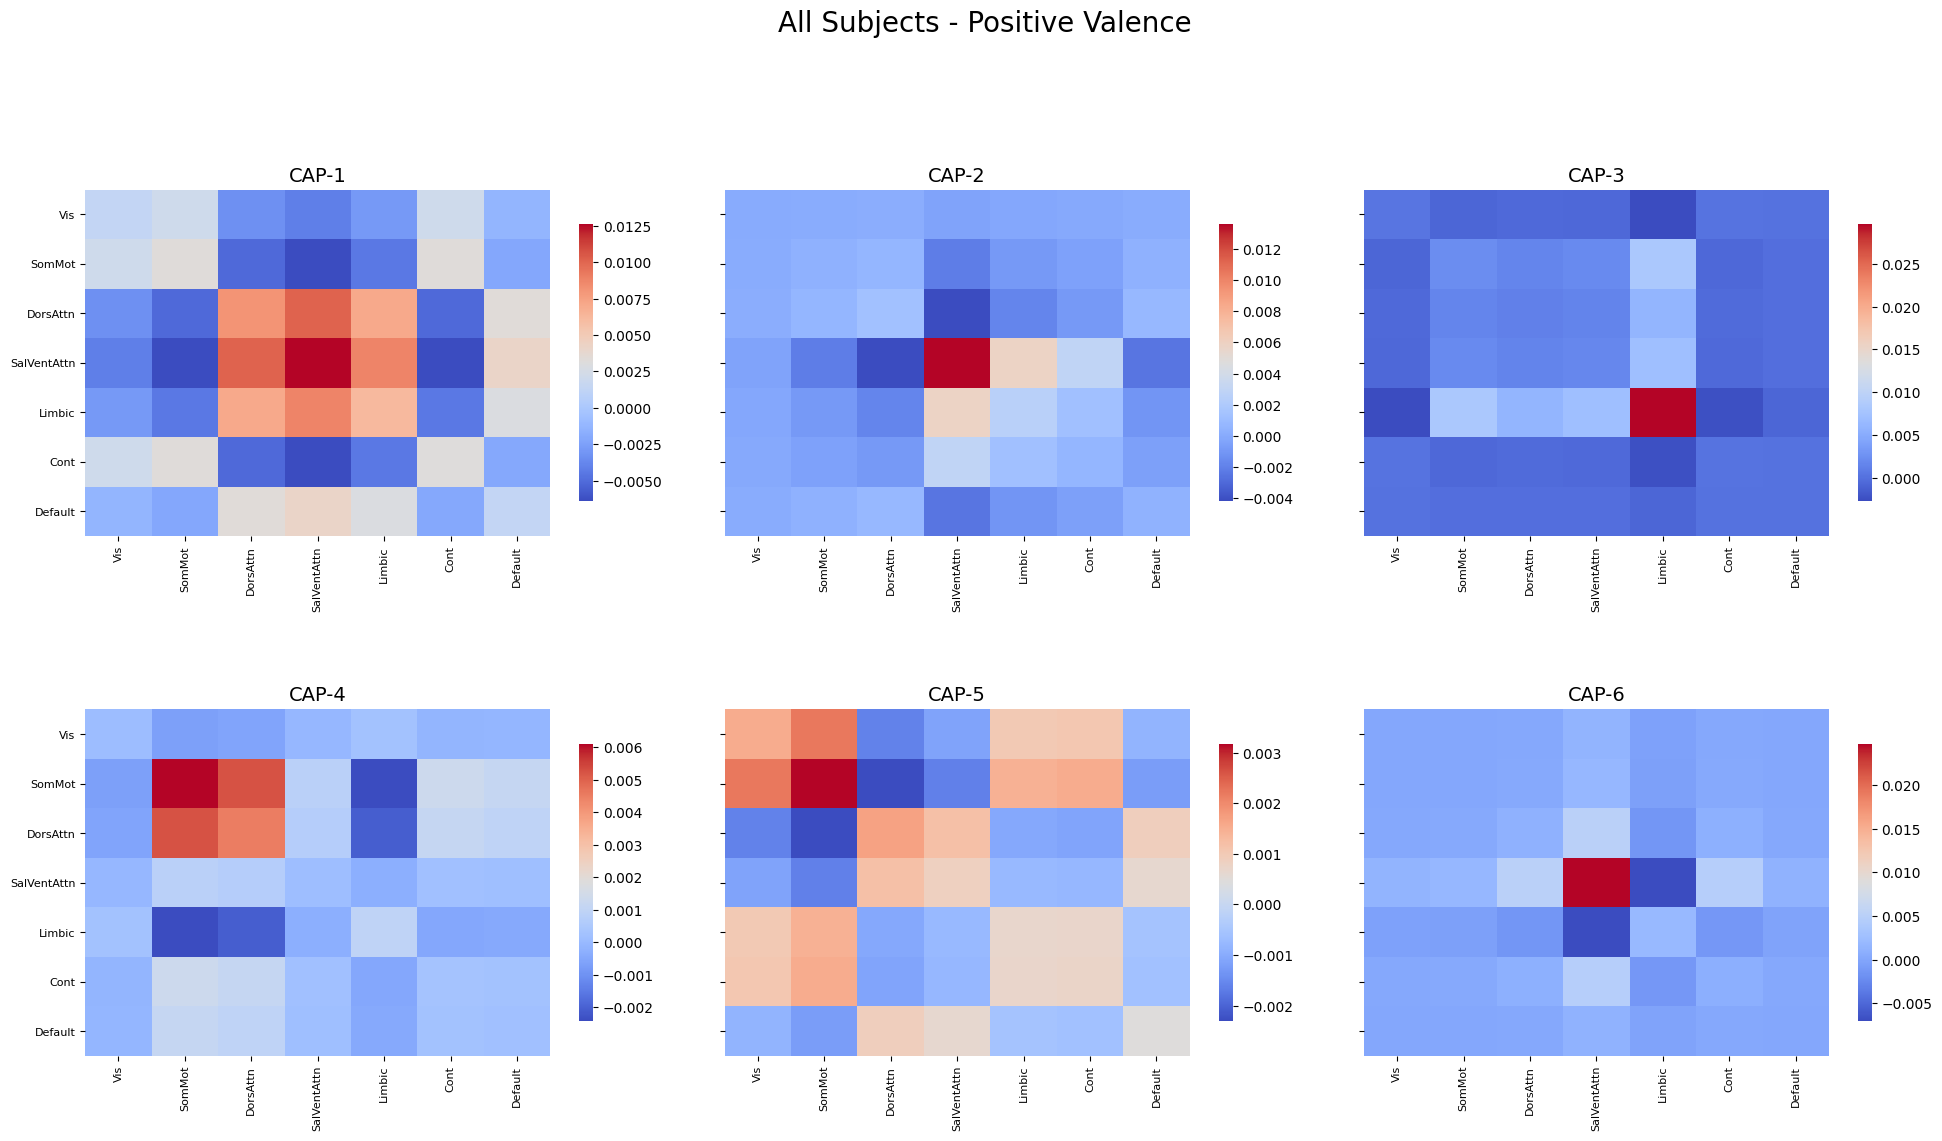

In [18]:
# Performing Cap analysis without groups or cluster selection method

cap_analysis = CAP(node_labels=extractor.parcel_approach["Schaefer"]["labels"], n_clusters=6)
cap_analysis.get_caps(subject_timeseries="sample_timeseries.pkl")

# invalid plotting keywords will be ignored and plottinf will continue
cap_analysis.visualize_caps(subplots=True, wspace = 0.1, hspace = 0.5, ncol=3, task_title="- Positive Valence", y = -3, xlabel_rotation=90, tight_layout=False, yticklabels_size=8, xticklabels_size=8)

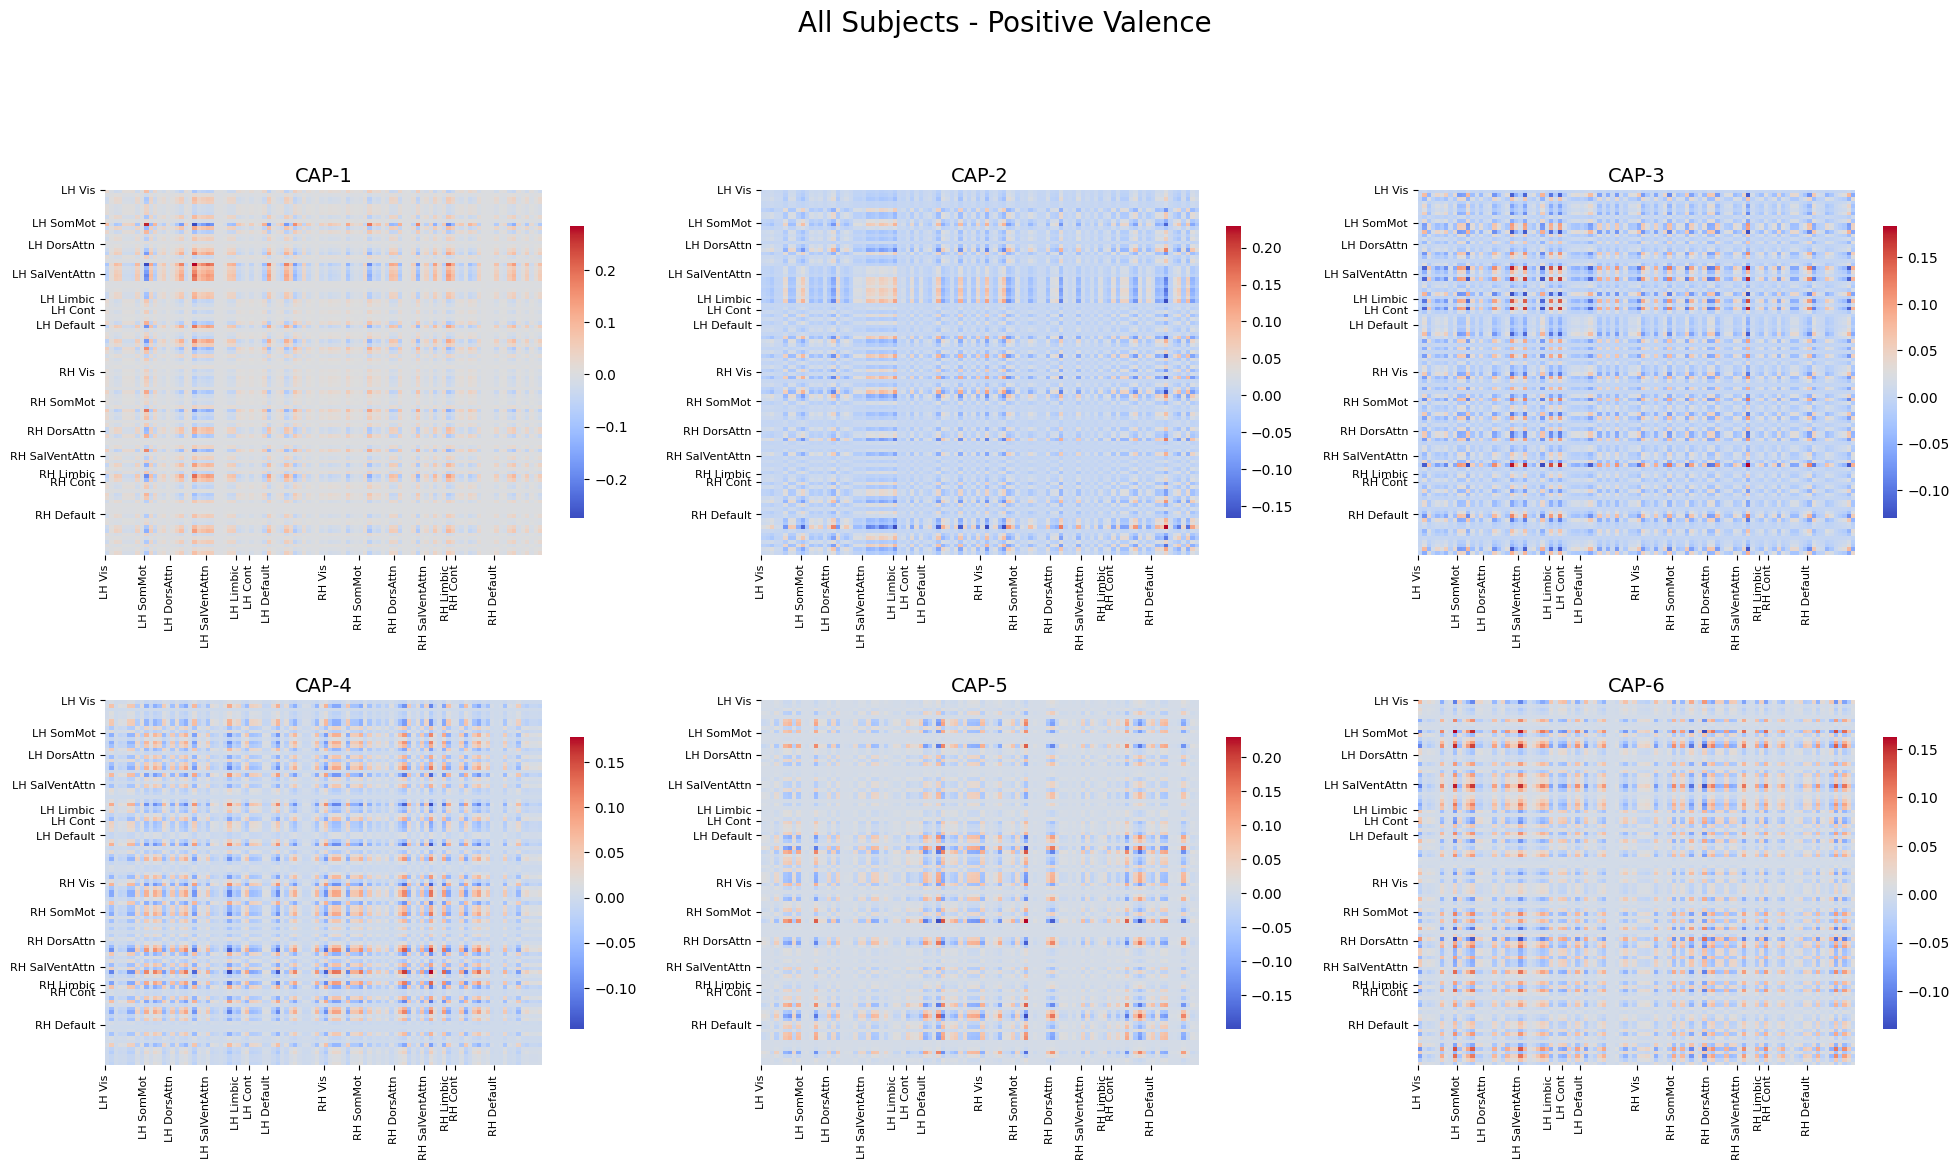

In [19]:
cap_analysis.visualize_caps(visual_scope="nodes", plot_options="outer product", task_title="- Positive Valence", ncol=3, sharey=False, subplots=True, xlabel_rotation = 90, tight_layout=False, hspace = 0.4)

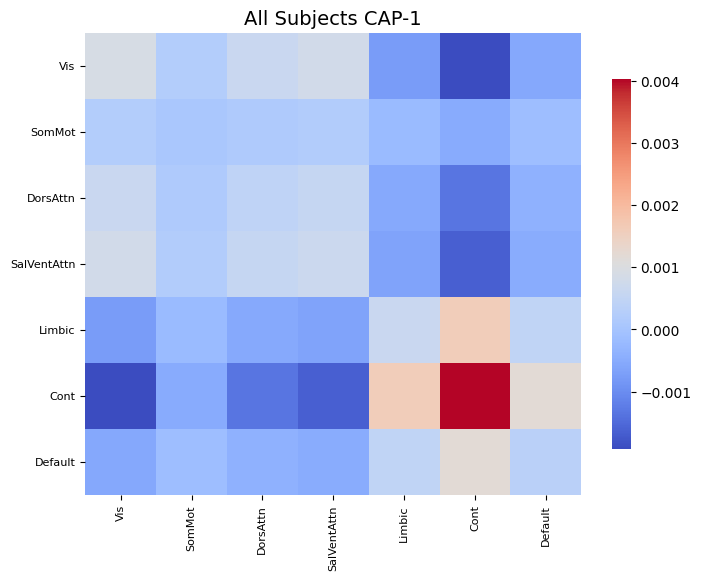

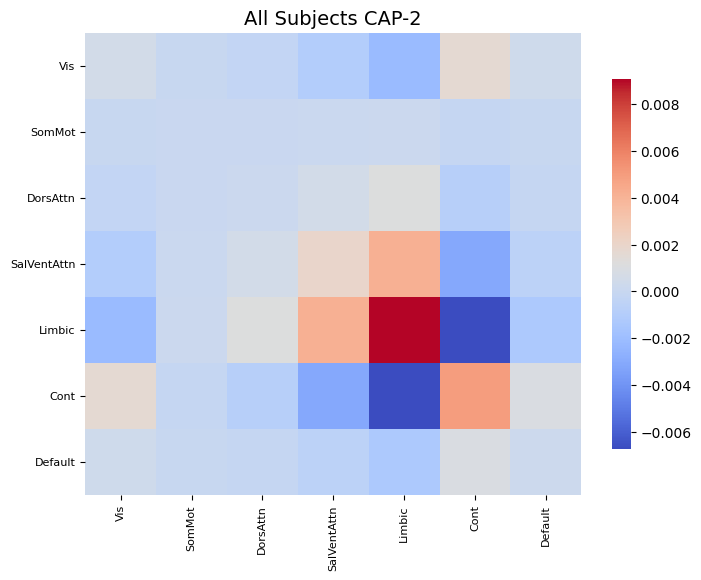

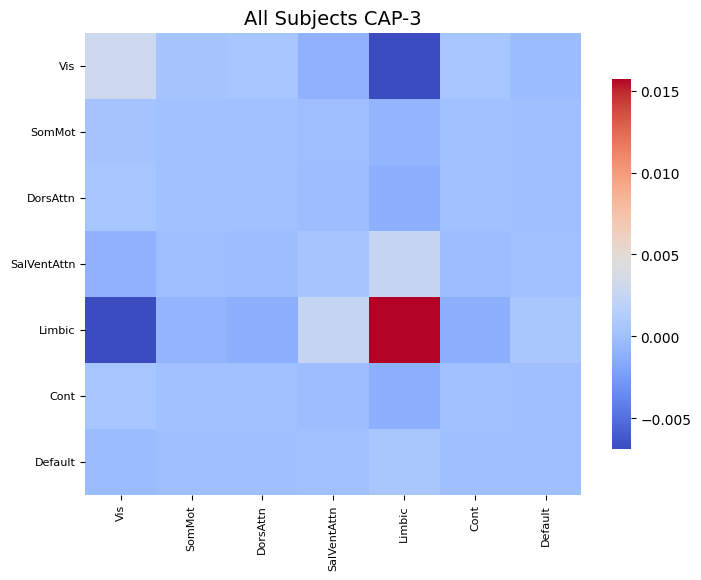

In [20]:
# Individual plots. In the event you wnat to merge TRs from two dictionaries conatining the same subject to find common CAPs across a task
subject_timeseries_1 = {str(x) : {f"run-{y}": np.random.rand(100,100) for y in range(1,4)} for x in range(1,11)}
subject_timeseries_2 = {str(x) : {f"run-{y}": np.random.rand(100,100) for y in range(1,4)} for x in range(1,11)}
# Includes `output_dir` and `file_name` parameters to save merge dictionary as a pickle file
subject_timeseries_combined = merge_dicts(subject_timeseries_list=[subject_timeseries_1, subject_timeseries_2], return_dict=True)
cap_analysis = CAP(node_labels=extractor.parcel_approach["Schaefer"]["labels"], n_clusters=3)
cap_analysis.get_caps(subject_timeseries=subject_timeseries_combined)
cap_analysis.visualize_caps(xlabel_rotation=90)

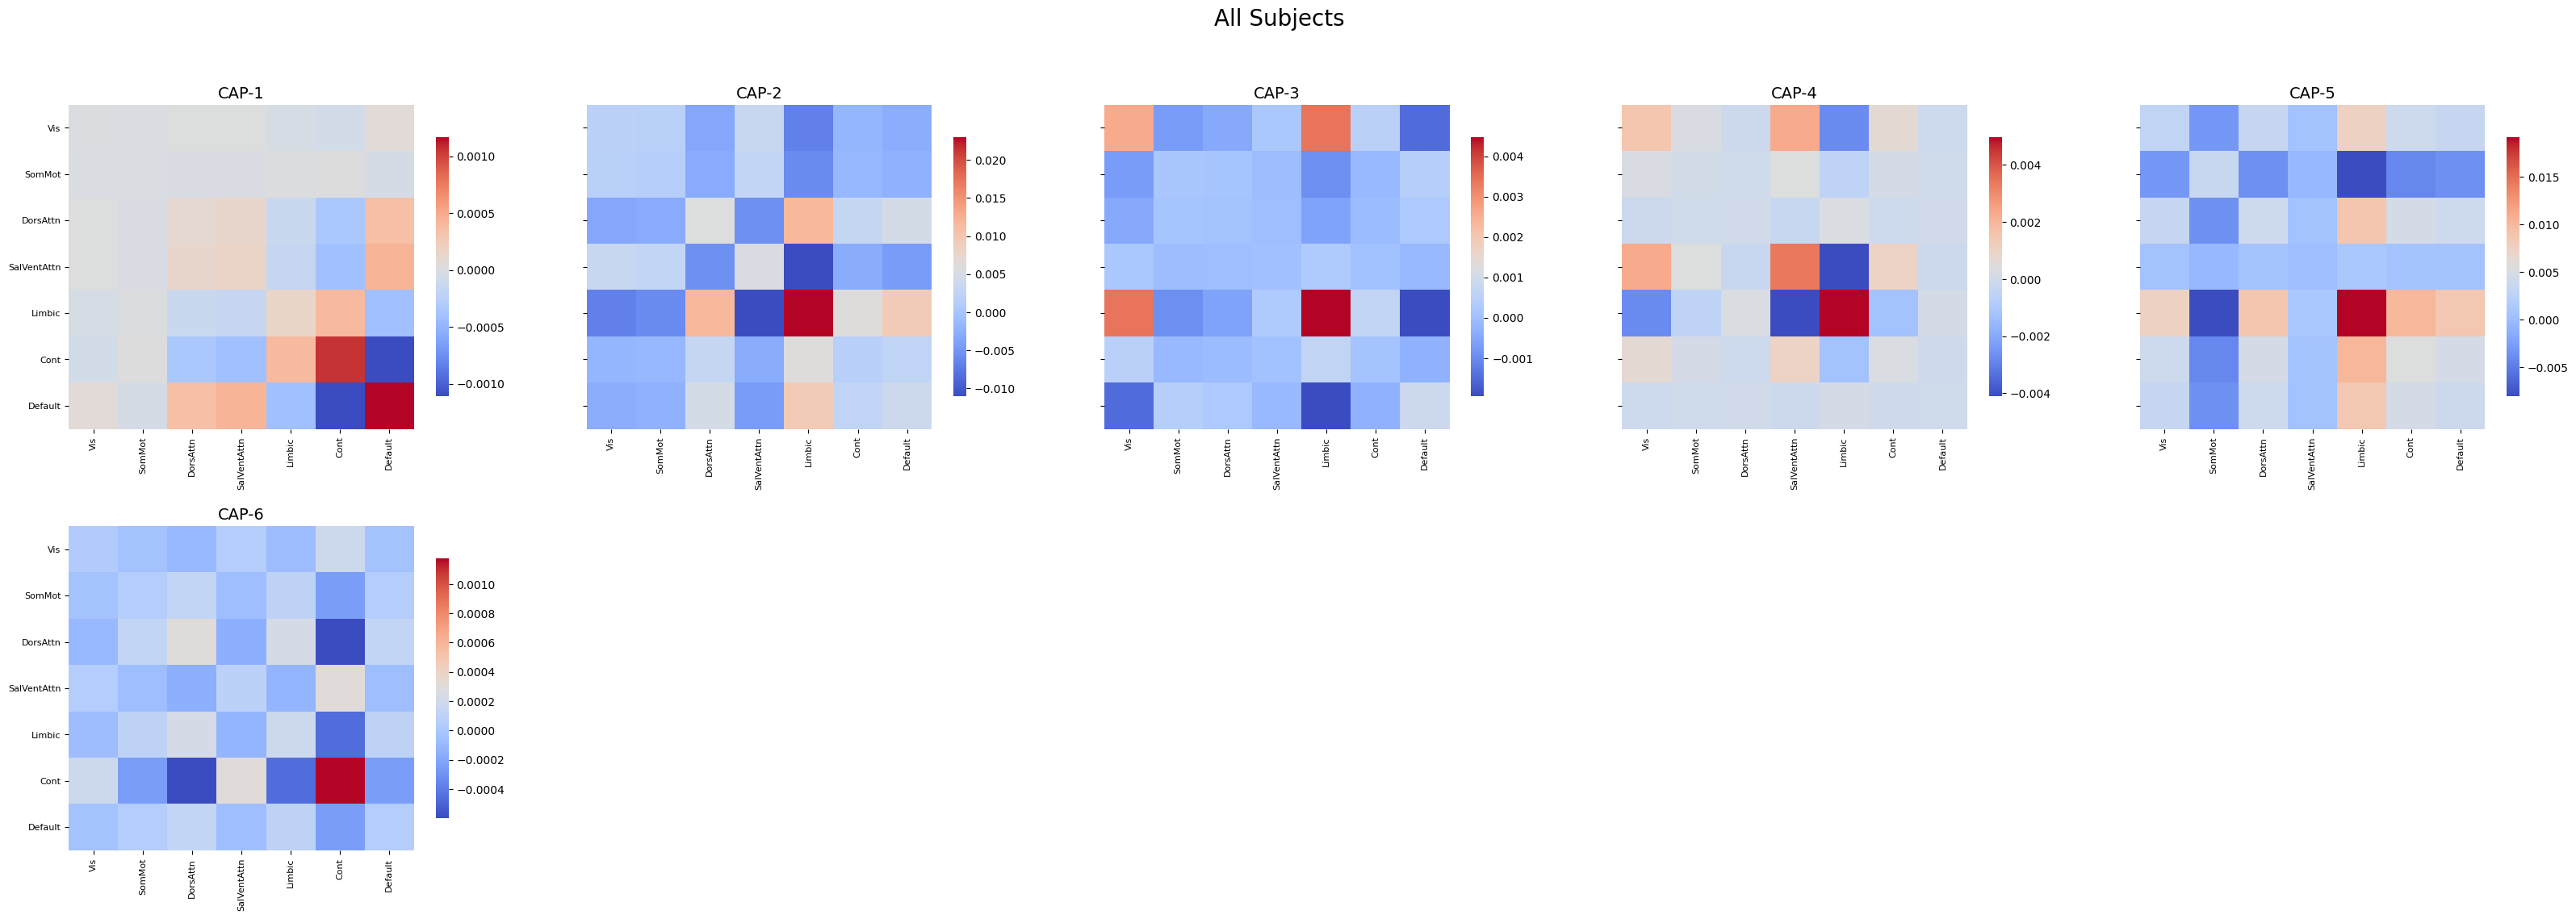

In [21]:
# Performing Cap analysis with no groups and no cluster selection method

cap_analysis = CAP(node_labels=extractor.parcel_approach["Schaefer"]["labels"], n_clusters=6)
cap_analysis.get_caps(subject_timeseries=extractor.subject_timeseries)
cap_analysis.visualize_caps(output_dir=output_dir, visual_scope="networks", plot_options="outer product", subplots=True, fontsize=14, xlabel_rotation=90, tight_layout=False, hspace=0.3)

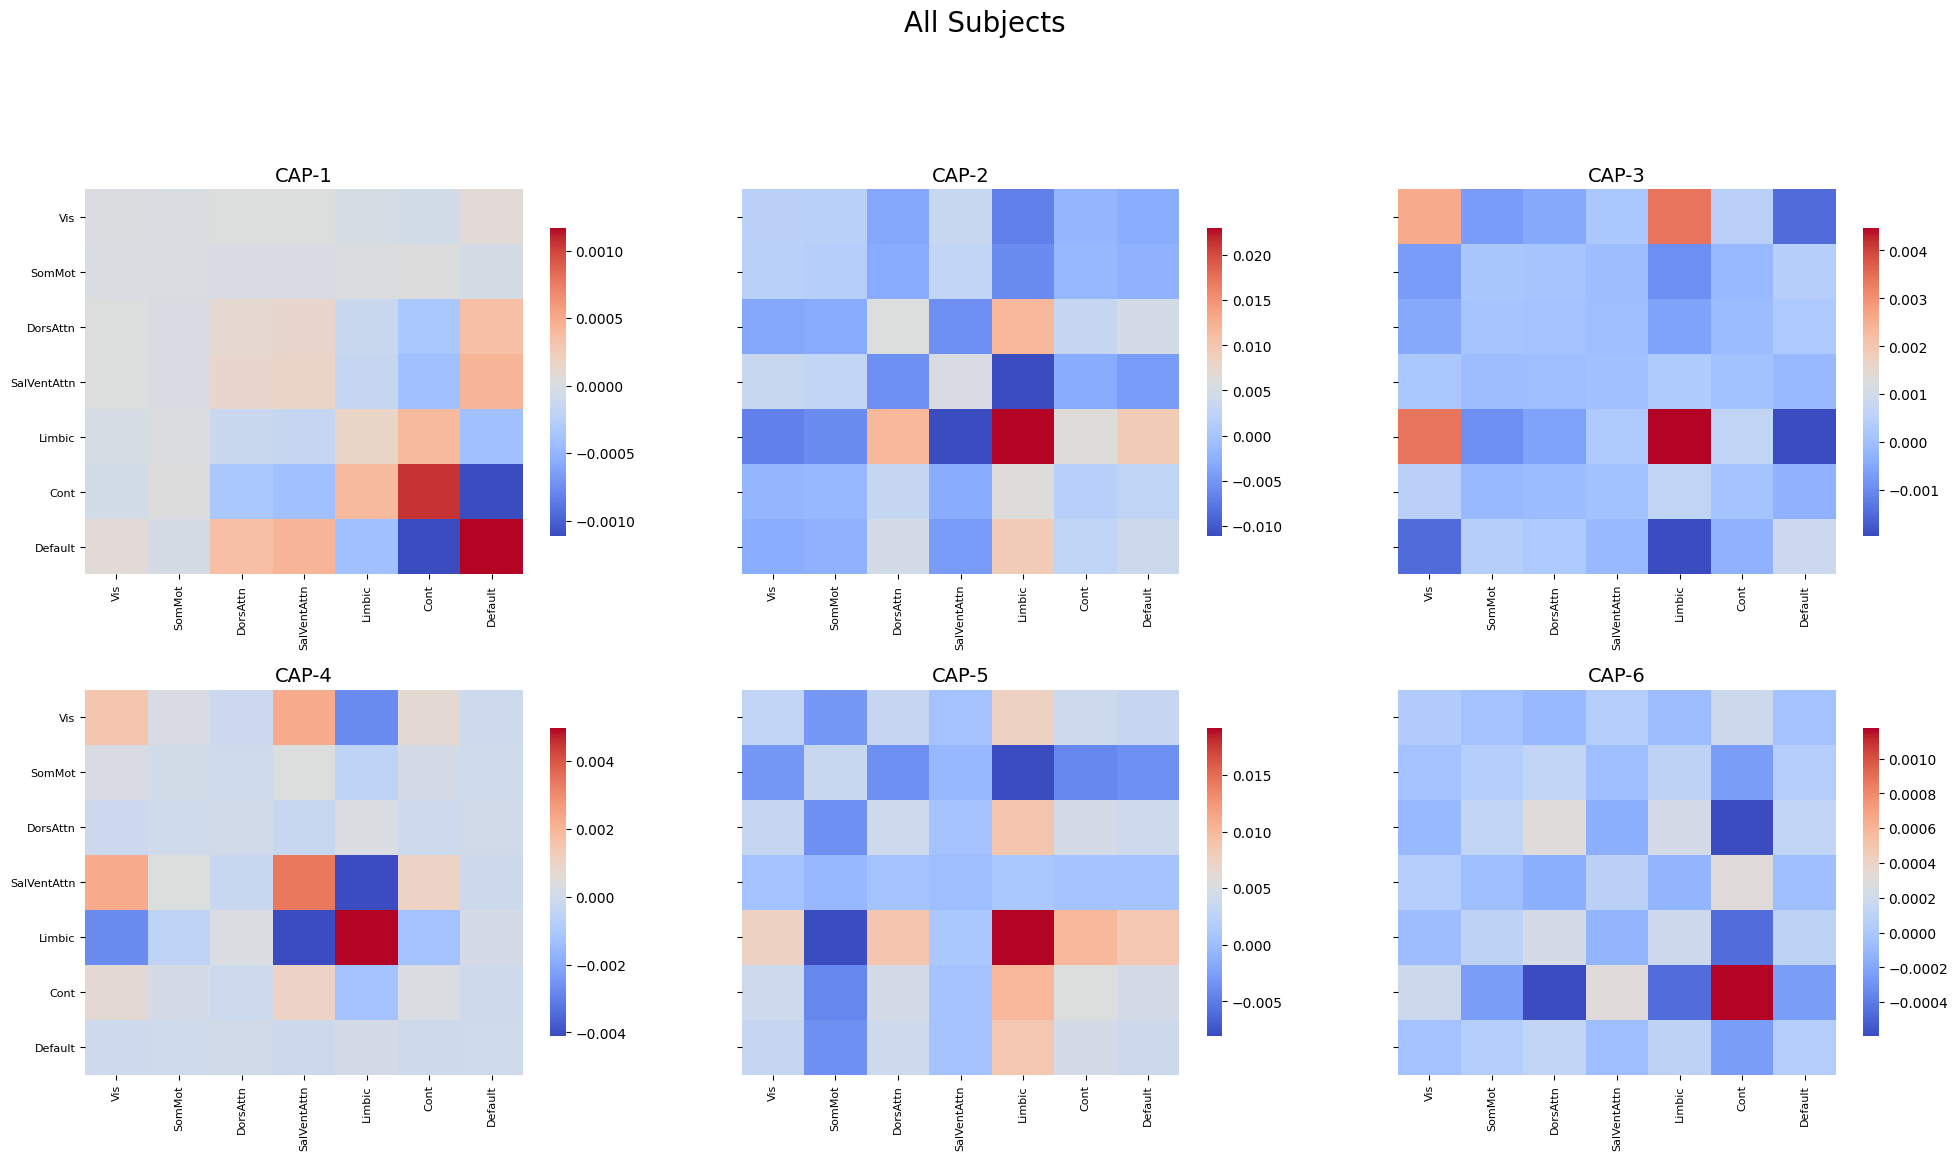

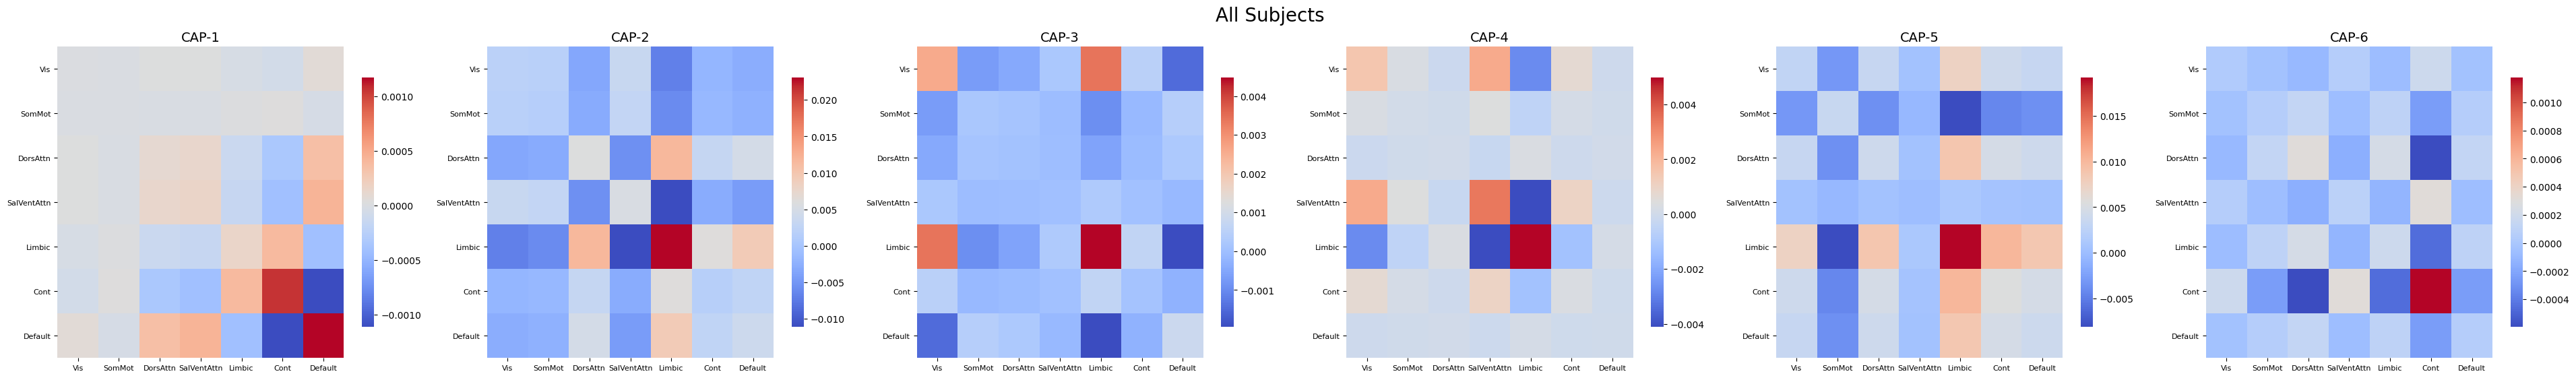

In [22]:
# Can change the number of columns for subplots. If none is specified, the default varies but will max out to five columns; however, yoe can specify more than five columns

cap_analysis.visualize_caps(output_dir=output_dir, visual_scope="networks", plot_options="outer product", subplots=True, fontsize=14, ncol=3, xlabel_rotation=90, tight_layout=False,  hspace = 0.3)
cap_analysis.visualize_caps(output_dir=output_dir, visual_scope="networks", plot_options="outer product", subplots=True, fontsize=14, ncol=6, sharey=False, tight_layout=False, xlabel_rotation=0, hspace = 0.3)

In [23]:
help(cap_analysis.visualize_caps)

Help on method visualize_caps in module neurocaps.analysis.cap:

visualize_caps(output_dir: str = None, plot_options: Union[str, list[str]] = 'outer product', visual_scope: list[str] = 'networks', task_title: str = None, show_figs: bool = True, subplots: bool = False, **kwargs) method of neurocaps.analysis.cap.CAP instance
    Plotting CAPs
    
    This function produces seaborn heatmaps for each CAP. If groups were given when the CAP class was initialized, plotting will be done for all CAPs for all groups.
    
    Parameters
    ----------
    output_dir: str, default=None
        Directory to save plots in. If None, plots will not be saved.
    plot_options: str or list[str], default="outer product"
        Type of plots to create. Options are "outer product" or "heatmap".
    visual_scope: str or list[str], default="networks
        Determines whether plotting is done at the network level or node level. For network level, the value of each nodes in the same networks are averaged t

In [24]:
output = cap_analysis.calculate_metrics(subject_timeseries=extractor.subject_timeseries,return_df=True,output_dir=output_dir, runs=[1,2],file_name="All_Subjects_CAPs_metrics")
output["temporal fraction"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3,CAP-4,CAP-5,CAP-6
0,1,All Subjects,run-1,0.16,0.17,0.21,0.19,0.14,0.13
1,1,All Subjects,run-2,0.21,0.20,0.15,0.13,0.15,0.16
2,2,All Subjects,run-1,0.15,0.14,0.12,0.21,0.21,0.17
3,2,All Subjects,run-2,0.15,0.15,0.28,0.13,0.11,0.18
4,3,All Subjects,run-1,0.19,0.17,0.16,0.21,0.13,0.14
5,3,All Subjects,run-2,0.12,0.19,0.08,0.21,0.24,0.16
6,4,All Subjects,run-1,0.17,0.14,0.20,0.18,0.15,0.16
7,4,All Subjects,run-2,0.16,0.16,0.24,0.14,0.19,0.11
8,5,All Subjects,run-1,0.19,0.11,0.17,0.15,0.26,0.12
9,5,All Subjects,run-2,0.11,0.15,0.18,0.23,0.16,0.17


In [25]:
output = cap_analysis.calculate_metrics(subject_timeseries=extractor.subject_timeseries,return_df=True, output_dir=output_dir, runs=[1,2], continuous_runs=True, file_name="All_Subjects_CAPs_metrics")
output["temporal fraction"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3,CAP-4,CAP-5,CAP-6
0,1,All Subjects,Continuous Runs,0.166667,0.196667,0.163333,0.173333,0.146667,0.153333
1,2,All Subjects,Continuous Runs,0.166667,0.156667,0.193333,0.160000,0.143333,0.180000
2,3,All Subjects,Continuous Runs,0.150000,0.186667,0.143333,0.173333,0.183333,0.163333
3,4,All Subjects,Continuous Runs,0.153333,0.166667,0.220000,0.163333,0.170000,0.126667
4,5,All Subjects,Continuous Runs,0.160000,0.156667,0.166667,0.193333,0.176667,0.146667
5,6,All Subjects,Continuous Runs,0.166667,0.153333,0.163333,0.160000,0.176667,0.180000
6,7,All Subjects,Continuous Runs,0.153333,0.156667,0.183333,0.163333,0.170000,0.173333
7,8,All Subjects,Continuous Runs,0.150000,0.213333,0.176667,0.166667,0.143333,0.150000
8,9,All Subjects,Continuous Runs,0.216667,0.163333,0.160000,0.160000,0.143333,0.156667
9,10,All Subjects,Continuous Runs,0.180000,0.193333,0.160000,0.150000,0.146667,0.170000


In [26]:
help(cap_analysis.calculate_metrics)

Help on method calculate_metrics in module neurocaps.analysis.cap:

calculate_metrics(subject_timeseries: Union[dict[dict[numpy.ndarray]], str], tr: float = None, runs: int = None, continuous_runs: bool = False, metrics: Union[str, list[str]] = ['temporal fraction', 'persistence', 'counts', 'transition frequency'], return_df: bool = True, output_dir: str = None, file_name: str = None) -> dict method of neurocaps.analysis.cap.CAP instance
    Get CAP metrics
    
    Creates a single pandas Dataframe containing all participants containing CAP metrics as described in Liu et al., 2018 and Yang et al., 2021, where `temporal fraction` is the proportion of total volumes spent in a single CAP over all volumes in a run,
    `persistence` is the average time spent in a single CAP before transitioning to another CAP (average consecutive/uninterrupted time), and `counts` is the frequency of each CAP observed in a run, and `transition frequency` is the number of switches between
    different CAPs